In [8]:
import os
import qiime2 as q2
import pandas as pd
import numpy as np
from skbio import OrdinationResults, TreeNode
from scipy.stats import pearsonr, spearmanr, ttest_ind
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.qurro.actions import differential_plot as qq2diffplot
from biom import Table
import glob
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from qiime2.plugins.phylogeny.methods import filter_table
#from qiime2.plugins.empress.actions import (community_plot, tree_plot)


import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
%matplotlib inline


# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12

def split_taxonomy(taxonomy):
    feat_map = dict(taxonomy.Taxon)
    taxonomy['Taxon'] = [feat_map[feat]
                         if feat in feat_map.keys()
                         else np.nan
                         for feat in taxonomy.index]
    # add taxonomic levels for grouping later (if available)

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxonomy.columns:
            taxonomy_tmp = []
            for tax in taxonomy.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxonomy[lname] = taxonomy_tmp
    return taxonomy



def differential_plot(diff_df, level, color_by, x_axis, ax,
                      xtitle='log($\\frac{responder}{non-responder}$)',
                      cbartitle='Seeding-Effectiveness',
                      quartile_partition=True,
                      upper=.75, lower=.25, cmap_use='RdYlBu',
                      ntfilter=0, ensure_include = [],
                      n_top_bottom_filter=False,
                      n_top_bottom=50):

    # axis of std
    x_axis_std = x_axis.replace('_mean','_std')
    # make colormap
    # group level
    diff_df_grouped = diff_df.groupby(level).mean()
    #diff_df_grouped = diff_df.copy()
    # filter N-total
    keep_ = [k for k,v in dict(diff_df[level].value_counts()).items()
             if v > ntfilter]
    diff_df = diff_df[diff_df[level].isin(keep_)]
    # keep quartiles
    if quartile_partition:
        quant_ = diff_df_grouped[x_axis].quantile([lower, .5, upper]).values
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] < quant_[0]].index)
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] > quant_[-1]].index)
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_ + ensure_include)]
    elif n_top_bottom_filter:  
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] > 0].index[:n_top_bottom//2])
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] <= 0].index[-n_top_bottom//2:])
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    # remove some chars.
    diff_df[level] = [v_.replace('[','').replace(']','')
                      for v_ in diff_df[level]]
    # ordering
    #diff_df_grouped = diff_df.groupby(level).mean()
    #order_ = diff_df_grouped[x_axis].sort_values(ascending=False).index
    #order_ = {j:i for i, j in enumerate(order_)}
    #diff_df['sort'] = [order_[v_] for v_ in diff_df[level]]
    # make a colorbar (first get colors by diffs.)
    #all_prop = diff_df.groupby(level).mean().fillna('nan')
    #coeff_ = all_prop[color_by].to_dict()
    #coeff_[np.nan] = np.nan
    # build the cmap
    # plot
    """sns.barplot(y=level,
                x=x_axis,
                palette=cmap_use,
                data=diff_df.sort_values('sort'),
                ax=ax,
                ci=68)"""
    # plot with std
    
    diff_df_grouped = diff_df.groupby(level).mean()
    diff_df_grouped[x_axis] -= diff_df_grouped[x_axis].mean()
    diff_df_grouped = diff_df_grouped.sort_values(x_axis)
    mean_values = diff_df_grouped[x_axis].values
    std_values = diff_df_grouped[x_axis_std].values
    y_labels = diff_df_grouped.index
    
    
    y_pos = np.arange(len(mean_values))
    #color = cm.ocean_r(np.linspace(.2, 1, len(y_labels)))
    color = cm.RdBu(np.linspace(0, 1, len(y_labels)))   
    
    pal_ = [c for i, c in zip(y_labels, color)]
    ax.barh(y_pos, mean_values, xerr=std_values, color=pal_,
            align='center', alpha=0.8, ecolor='black', capsize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)

    ax.set_ylabel('')
    ax.set_xlabel(xtitle,
                  color='black',
                  weight='bold',
                  fontsize=22)
    
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax, diff_df_grouped


In [9]:
table_metag = q2.Artifact.load('../data/metaG/metaG-matched-table.qza')
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza').to_dataframe()
tree_metag = q2.Artifact.load('../data/metaG/wol_tree.qza')
table_metag = filter_table(table_metag, tree_metag).filtered_table
bt_table_metag = table_metag.view(Table)

coverage = pd.read_csv('../data/coverage.tsv', sep='\t', index_col=0)
coverage = coverage[coverage.coverage_ratio > 0.5]

# filter and match the table
n_features, n_samples = bt_table_metag.shape
min_feature_frequency = 10
min_feature_count = 0
min_sample_count = 500000
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
    
    
bt_table_metag = bt_table_metag.filter(set(coverage.index) & set(bt_table_metag.ids('observation')),
                                       axis='observation')
bt_table_metag = bt_table_metag.filter(bt_table_metag.ids()[(bt_table_metag.sum('sample') > min_sample_count)])
bt_table_metag = bt_table_metag.filter(observation_filter, axis='observation')
bt_table_metag = bt_table_metag.filter(frequency_filter, axis='observation')
metadata_metag = metadata_metag.reindex(bt_table_metag.ids())


In [10]:

diffs = pd.read_csv('../results/metaG/summarized_differentials.tsv', sep='\t', index_col=0).reindex(bt_table_metag.ids('observation'))
taxonomy = q2.Artifact.load('../data/metaG/wol_taxonomy.qza').view(q2.Metadata).to_dataframe()
taxonomy = split_taxonomy(taxonomy)
taxonomy = taxonomy.dropna(subset=['genus'])
taxonomy = taxonomy[~taxonomy.genus.isin(['Haemophilus','Yersinia','Brachyspira','Vibrio','Basfia',
                                          'Gallibacterium','Azospirillum'])]
taxonomy = taxonomy[~taxonomy.species.isin(['Acinetobacter sp. CAG:196','Dialister invisus CAG:218',
                                            'Sutterella wadsworthensis CAG:135', 'Bacillus sp. CAG:988', 
                                            'Candidatus Methanomassiliicoccus intestinalis',])]
taxonomy['strain'] = taxonomy.species + ' (' + taxonomy.index + ')'
diffs.head(5)


,Intercept_mean,diet_nocross[T.Ketogenic Diet]_mean,cog[T.NC]_mean,first_diet_mean,timepoint_encoded_mean,Intercept_std,diet_nocross[T.Ketogenic Diet]_std,cog[T.NC]_std,first_diet_std,timepoint_encoded_std
Feature,,,,,,,,,,
G000006865,-9.671048,0.493086,0.620899,-1.146848,0.024764,1.536311,0.447470,0.961889,0.943327,0.173451
G000006925,-7.670659,1.020797,-0.281920,-0.344451,0.028232,1.578980,0.515620,1.003541,0.991088,0.201410
G000007525,-7.361210,-0.753928,1.102107,-1.484313,-0.261979,1.566943,0.545594,0.977061,1.043054,0.171090
G000008865,-7.379494,1.016648,-0.377352,-0.426193,0.028701,1.660930,0.513717,1.011896,1.032078,0.196837
G000009925,-5.295181,0.163277,0.606519,-0.662728,-0.025668,1.315848,0.086574,0.860976,0.862896,0.029536


In [11]:
diff_plot = {"D1:D2":"first_diet_mean",
             "CN:MCI":"cog[T.NC]_mean",
             "t0:t5":"timepoint_encoded_mean",
             "Ketogenic:Low-Fat":"diet_nocross[T.Ketogenic Diet]_mean"}


microbe_diff_df_plot = diffs.copy()
microbe_diff_df_plot.head(5)


,Intercept_mean,diet_nocross[T.Ketogenic Diet]_mean,cog[T.NC]_mean,first_diet_mean,timepoint_encoded_mean,Intercept_std,diet_nocross[T.Ketogenic Diet]_std,cog[T.NC]_std,first_diet_std,timepoint_encoded_std
Feature,,,,,,,,,,
G000006865,-9.671048,0.493086,0.620899,-1.146848,0.024764,1.536311,0.447470,0.961889,0.943327,0.173451
G000006925,-7.670659,1.020797,-0.281920,-0.344451,0.028232,1.578980,0.515620,1.003541,0.991088,0.201410
G000007525,-7.361210,-0.753928,1.102107,-1.484313,-0.261979,1.566943,0.545594,0.977061,1.043054,0.171090
G000008865,-7.379494,1.016648,-0.377352,-0.426193,0.028701,1.660930,0.513717,1.011896,1.032078,0.196837
G000009925,-5.295181,0.163277,0.606519,-0.662728,-0.025668,1.315848,0.086574,0.860976,0.862896,0.029536


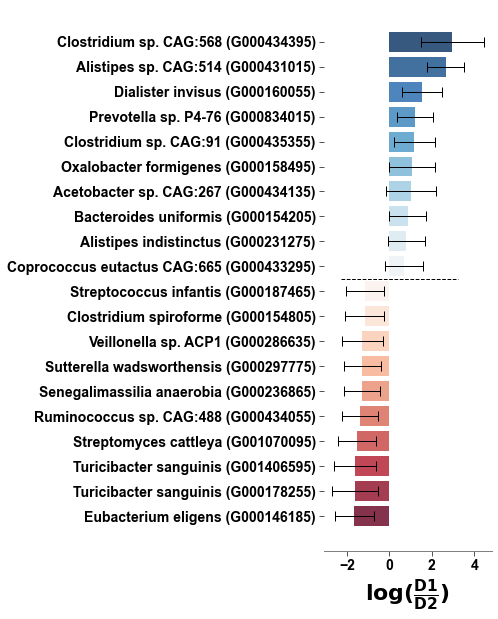

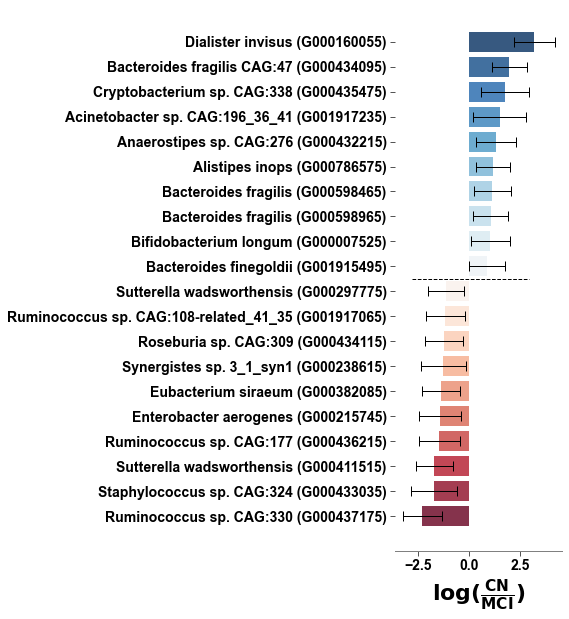

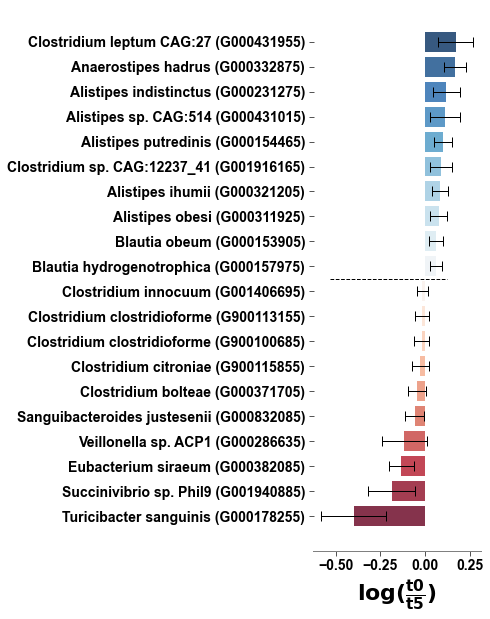

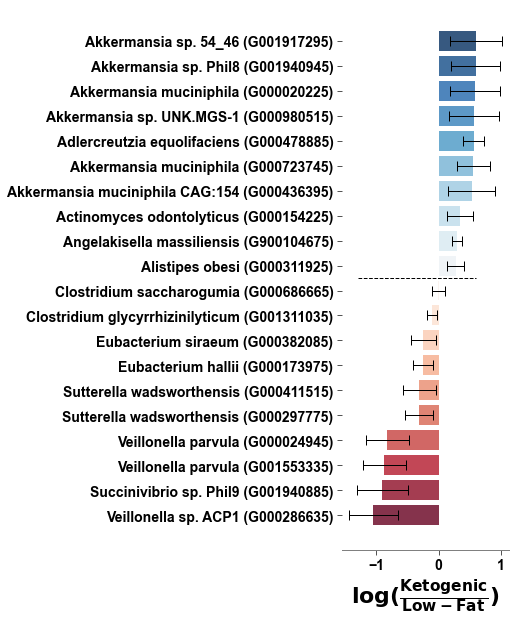

In [12]:


level = 'strain'

birdman_filttmp = {}

for label, diff_col in diff_plot.items():
    
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 10))

    #diff_col = "C(condition, Treatment('FT'))[T.FA]"
    micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
    #if 'Ketogenic' in  label:
    micro_comparedf = micro_comparedf[micro_comparedf[diff_col].abs() > micro_comparedf[diff_col.replace('_mean','_std')].abs()]

    title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label.split(':')[0], label.split(':')[1])
    ax, df_tmp = differential_plot(micro_comparedf,
                                   level, diff_col, diff_col,
                                   ax,
                                   quartile_partition=False,
                                   ntfilter=0,
                                   n_top_bottom_filter=True,
                                   n_top_bottom=20,
                                   #upper=.99, lower=.01, 
                                   xtitle=title_)
    birdman_filttmp[label] = df_tmp

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    #ax.set_xlim(-3, 3)
    #ax.spines['bottom'].set_bounds(-2, 2)
    ax.axhline((len(list(ax.get_yticklabels())) // 2) - .5,
               c='black', ls='--', lw=1,
               xmin=0.1, xmax=0.8)

    
    #plt.tight_layout()
    plt.savefig('../results/figures/ranking_%s.pdf' % (diff_col),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.savefig('../results/figures/low-res-ranking_%s.png' % (diff_col),dpi=250, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()


In [13]:
# taxonomy_map
taxonomy_map = pd.read_csv('../data/wol/wol-organism-tax.tsv', sep='\t', index_col=0, header=None)
taxonomy_map.columns = ['strain']
taxonomy_map['genus'] = [x.split(' ')[0] for x in taxonomy_map['strain']]
taxonomy_map['species'] = [' '.join(x.split(' ')[:2]) for x in taxonomy_map['strain']]


# each genome prot
genome_to_prot = pd.read_csv('../data/wol/metacyc/protein.map.xz', sep='\t', header=None)

# prot to enzrxn
prot_to_enzrxn_file = open('../data/wol/metacyc/protein-to-gene.txt', 'r')
prot_to_enzrxn = [[l.lstrip().rstrip().replace('\n', '') for l in line.split('\t')] 
                  for line in prot_to_enzrxn_file]
prot_to_enzrxn_file.close()
prot_to_enzrxn_map = {names_tmp[0]:names_tmp[1:] for names_tmp in prot_to_enzrxn}
genome_to_prot[2] = [prot_to_enzrxn_map[v] if v in prot_to_enzrxn_map.keys() else np.nan for v in genome_to_prot[1]]
genome_to_prot = genome_to_prot.dropna(subset=[2])

bsh_sp = set(taxonomy_map.loc[[x.split('_')[0] for x in genome_to_prot[genome_to_prot[1] == 'MONOMER-15684'][0]], :].species)
other_genomes = set(taxonomy.species) - bsh_sp



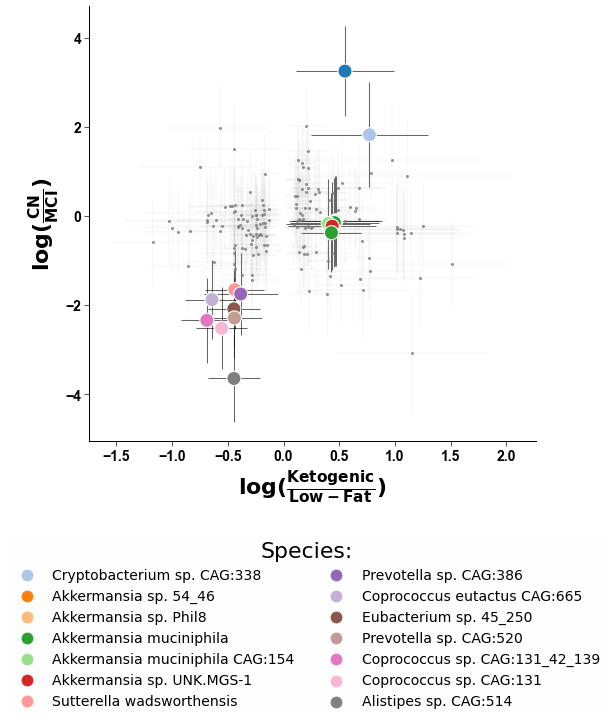

In [14]:

fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]

micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]



micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -0.25) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1.5) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > 0.4)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > 1.5)) 
                                               | (micro_comparedf.genus == 'Akkermansia'))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('genus')

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='species', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
                   loc=2, 
                         bbox_to_anchor=(-0.2, -0.2),
                         prop={'size':14},
                         title="Species:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=5.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()


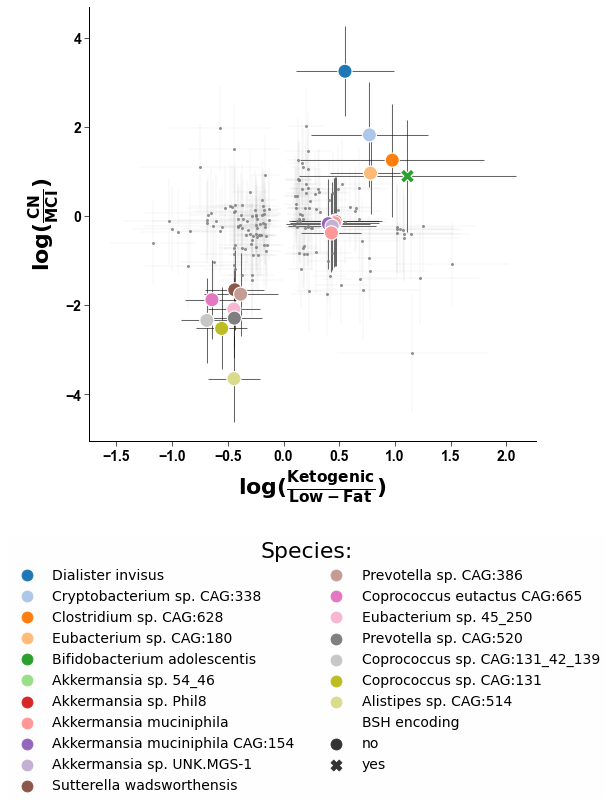

In [15]:

fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]

micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]


keep_bsh = set(taxonomy[taxonomy.species.isin(bsh_sp)].index) & set(micro_comparedf.index)

micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -0.25) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1.5) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > 0.4)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > 0.8)) 
                                               | (micro_comparedf.genus == 'Akkermansia'))]
# | (micro_comparedf.index.isin(keep_bsh))
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('genus')

bsh_lbl = set(taxonomy[taxonomy.species.isin(bsh_sp)].index) & set(micro_comparedf_subset_color.index)
micro_comparedf_subset_color['BSH encoding'] = 'no'
micro_comparedf_subset_color.loc[bsh_lbl, 'BSH encoding'] = 'yes'

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='species', style='BSH encoding', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
                   loc=2, 
                         bbox_to_anchor=(-0.2, -0.2),
                         prop={'size':14},
                         title="Species:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=5.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

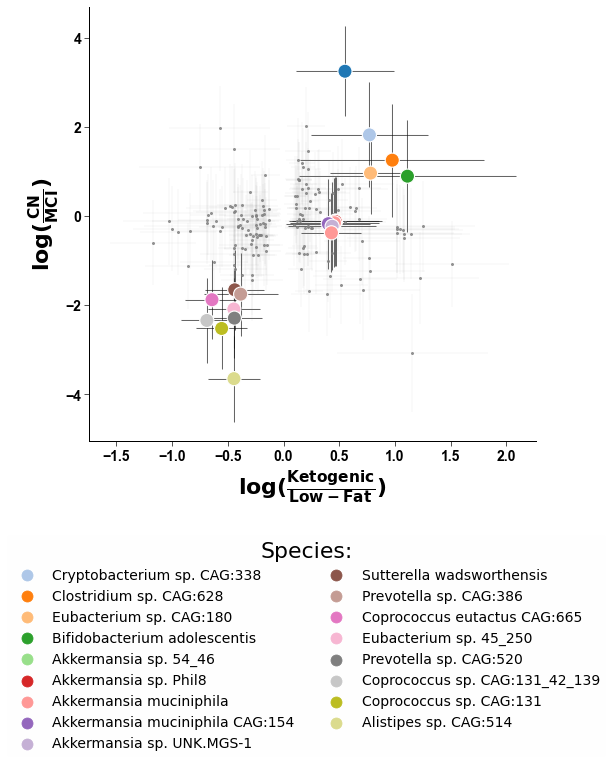

In [16]:

fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]

micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]


keep_bsh = set(taxonomy[taxonomy.species.isin(bsh_sp)].index) & set(micro_comparedf.index)

micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -0.25) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1.5) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > 0.4)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > 0.8)) 
                                               | (micro_comparedf.genus == 'Akkermansia'))]
# | (micro_comparedf.index.isin(keep_bsh))
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('genus')

bsh_lbl = set(taxonomy[taxonomy.species.isin(bsh_sp)].index) & set(micro_comparedf_subset_color.index)
micro_comparedf_subset_color['BSH encoding'] = 'no'
micro_comparedf_subset_color.loc[bsh_lbl, 'BSH encoding'] = 'yes'

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='species',  data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
                   loc=2, 
                         bbox_to_anchor=(-0.2, -0.2),
                         prop={'size':14},
                         title="Species:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=5.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

In [17]:

# make feature metadata
fmeta = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=['Intercept_mean'])
fmeta.index.name = 'featureid'
fmeta = q2.Metadata(fmeta)

# make tree filter
tree_metag_filter = tree_metag.view(TreeNode)
tree_metag_filter = tree_metag_filter.shear(fmeta.to_dataframe().index)
tree_metag_filter = q2.Artifact.import_data('Phylogeny[Rooted]', tree_metag_filter)

# add phylogeny plot
tree_plot_res = tree_plot(tree_metag_filter, feature_metadata=fmeta)
tree_plot_res.visualization.save('../results/metaG/tree-diffs.qzv')


NameError: name 'tree_plot' is not defined

In [18]:

btlr = table_metag.view(Table).to_dataframe() + 1
mflr = metadata_metag.copy().reindex(btlr.columns).dropna(subset=['timepoint_encoded'])
mflr.head(5)


,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,...,taxon_id,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross,timepoint_encoded
13662.5555659,62,1263001,27.92,31102 Stool Box 1,2/4/15,2015-02-11,fecal sample Pre 1 3AWFR000081,300.0,Host-associated,Animal,...,408170.0,Pre 1,BEAM_U19,0005555659,mg,PreA-Cog,MCI,Ketogenic Diet,Ketogenic Diet,1.0
13662.5555660,62,1263001,27.92,31102 Stool Box 1,3/24/15,2015-03-25,fecal sample Post 1 3AWFR000081,300.0,Host-associated,Animal,...,408170.0,Post 1,BEAM_U19,0005555660,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet,2.0
13662.5555661,62,1263001,27.92,31102 Stool Box 1,5/5/15,2015-05-07,fecal sample FU 1 / Pre 2 3AWFR000081,300.0,Host-associated,Animal,...,408170.0,FU 1 / Pre 2,BEAM_U19,0005555661,mg,PREB-COG,MCI,Keto-to-AHA Crossover,AHA Diet,3.0
13662.5555662,62,1263001,27.92,31102 Stool Box 1,6/17/15,2015-06-22,fecal sample Post 2 3AWFR000081,300.0,Host-associated,Animal,...,408170.0,Post 2,BEAM_U19,0005555662,mg,POSTB-COG,MCI,AHA Diet,AHA Diet,4.0
13662.5555663,62,1263001,27.92,31102 Stool Box 1,8/3/15,2015-08-04,fecal sample FU 2 3AWFR000081,300.0,Host-associated,Animal,...,408170.0,FU 2,BEAM_U19,0005555663,mg,POSTB-FU,MCI,AHA Diet,AHA Diet,5.0


In [19]:
def diet_plotting_col(x):
    if x['timepoint_encoded']==3: 
        if x['diet']=='AHA-to-Keto Crossover':
            return 'AHA Washout'
        elif x['diet']=='Keto-to-AHA Crossover':
            return 'Keto Washout'
    elif x['timepoint_encoded']==5:
        if x['diet']=='AHA Diet':
            return 'AHA Washout'
        elif x['diet']=='Ketogenic Diet':
            return 'Keto Washout'
    return x['diet'] 

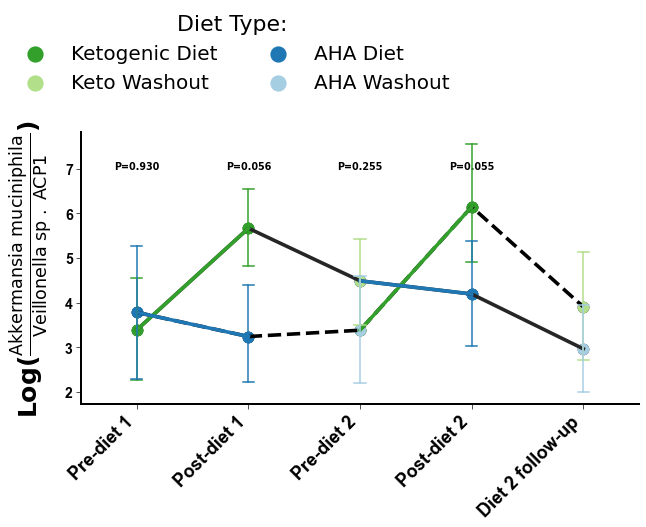

In [20]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
            'AHA Washout':'#a6cee3',
            'Keto Washout':'#b2df8a',
            'Ketogenic Diet':'#33a02c'}

"""['Akkermansia muciniphila',
               'Akkermansia muciniphila CAG:154',
               'Akkermansia sp. UNK.MGS-1',
               'Akkermansia sp. 54_46',
               'Akkermansia sp. Phil8']"""

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

num_use = ['Akkermansia muciniphila']
denom_use = ['Veillonella parvula']

axn_i = 0

num = taxonomy[taxonomy.species.isin(num_use)].index
den = taxonomy[taxonomy.species.isin(denom_use)].index

lr = np.log(btlr.loc[num, :].sum(0)) - np.log(btlr.loc[den, :].sum(0))
lr[~np.isfinite(lr)] = np.nan
mflr['log_ratio'] = lr


orddf = mflr.copy()

denom_use_label = [x.replace('[', '').replace(']', '') for x in denom_use]
denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
num_use_label = [x.replace('[', '').replace(']', '') for x in num_use]
num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
num_use_label = ['Akkermansia muciniphila']
denom_use_label = ['Veillonella sp . ACP1']


label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
              data=orddf, color='black', ci=None, ax=ax,
              linestyles=['-','--'], errwidth=0)

# draw from point 1 to point 2 
# make nans at PC1 for everything except point1 and point2 
orddf_12 = orddf.copy()
orddf_12.loc[orddf_12['timepoint_encoded'] > 2, 'log_ratio'] = np.nan
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_nocross',
             data=orddf_12, palette=cmap_man, ax=ax, ci=None)

# draw from point 3 to point 4 
# make nans at PC1 for everything except point3 and point4 
orddf_34 = orddf.copy()
orddf_34.loc[(orddf_34['timepoint_encoded'] < 3) | (orddf_34['timepoint_encoded'] == 5),'log_ratio'] = np.nan
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_nocross',
             data=orddf_34, palette=cmap_man, ax=ax, ci=None)

orddf['diet_plotting'] = orddf.apply(diet_plotting_col, axis=1)
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_plotting',
              data=orddf, ci=68, ax=ax, palette=cmap_man,
              errwidth=1.5, capsize=0.1, join=False)

relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 
                 3:'Pre-diet 2', 4:'Post-diet 2', 
                 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=25)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

#ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(0, 8)
#ax.set_ylim(0, 8)

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[6:], labels[6:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                 orddf,
                 groups=orddf["host_subject_id"])
mdf = md.fit()
mdf_table = mdf.summary().tables[1]

for x_i, ind in enumerate(['Period[T.Pre-diet 1]', 'Period[T.Post-diet 1]',
                           'Period[T.Pre-diet 2]', 'Period[T.Post-diet 2]']):
    


    p_str = "P=%s" % (mdf_table.loc[ind, 'P>|z|'])
    ax.text(x_i , 7,
            p_str,
            horizontalalignment='center',
            size='medium', color='black', weight='semibold')

    
plt.show()


In [21]:
taxonomy.loc['G000426745',:]

Taxon      k__Bacteria; p__Firmicutes; c__Negativicutes; ...
kingdom                                             Bacteria
phylum                                            Firmicutes
class                                          Negativicutes
order                                         Veillonellales
family                                       Veillonellaceae
genus                                            Veillonella
species                         Veillonella montpellierensis
strain             Veillonella montpellierensis (G000426745)
Name: G000426745, dtype: object

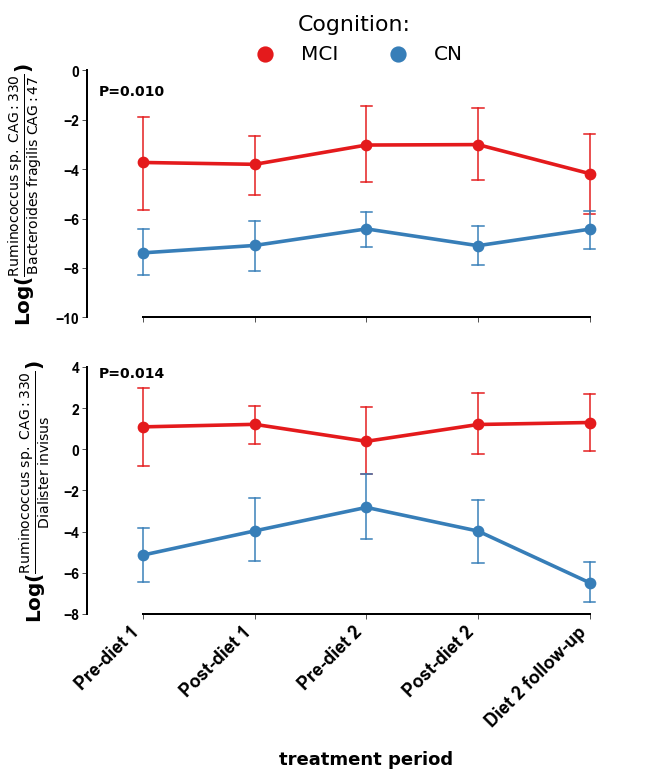

In [22]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10, 10), sharex=True)

num_use = ['Ruminococcus sp. CAG:330']
denoms_use = [['Bacteroides fragilis CAG:47'],
              ['Dialister invisus'],
              ]

for (axn_i, ax), denom_use in zip(enumerate(axn), denoms_use):

    num = taxonomy[taxonomy.species.isin(num_use)].index
    den = taxonomy[taxonomy.species.isin(denom_use)].index

    lr = np.log(btlr.loc[num, :].sum(0)) - np.log(btlr.loc[den, :].sum(0))
    lr[~np.isfinite(lr)] = np.nan
    mflr['log_ratio'] = lr


    orddf = mflr.copy()
    
    denom_use_label = [x.replace('[', '').replace(']', '') for x in denom_use]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in num_use]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    
    
    label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                           ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))



    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='cog',
                 data=orddf, palette=cmap_man, ci=68, ax=ax,
                 errwidth=1.5, capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='bold',
                  labelpad=10,
                  fontsize=20)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    #ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
    #                             orddf['log_ratio'].max().round(1) - 2)
    #ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
    #             orddf['log_ratio'].max().round(1) - 2)
    


    if axn_i == 0:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:],
                           [l.replace('NC','CN') for l in labels[:]],
                           loc=2, 
                                 bbox_to_anchor=(0.25, 1.3),
                                 prop={'size':20},
                                 title="Cognition:",
                                 fancybox=False, framealpha=.0,
                                 ncol=2, markerscale=1.5)
        legend.get_title().set_fontsize('22')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
            
        ax.spines['left'].set_bounds(-10, 0)
        ax.set_ylim(-10, 0)
        
        orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
        orddf['Sequence'] = orddf['first_diet']
        orddf['Diet'] = orddf['diet_nocross']
        md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                         orddf,
                         groups=orddf["host_subject_id"])
        mdf = md.fit()
        mdf_table = mdf.summary().tables[1]
        p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
        ax.text(-.1, -1, p_str, fontsize=14,
                    horizontalalignment='center',
                    color='black', weight='semibold')


    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.spines['left'].set_bounds(-8, 4)
        ax.set_ylim(-8, 4)
        
        ax.legend_.remove()
 
        orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
        orddf['Sequence'] = orddf['first_diet']
        orddf['Diet'] = orddf['diet_nocross']
        md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                         orddf,
                         groups=orddf["host_subject_id"])
        mdf = md.fit()
        mdf_table = mdf.summary().tables[1]
        p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
        ax.text(-.1, 3.5, p_str, fontsize=14,
                    horizontalalignment='center',
                    color='black', weight='semibold')


    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    




plt.show()

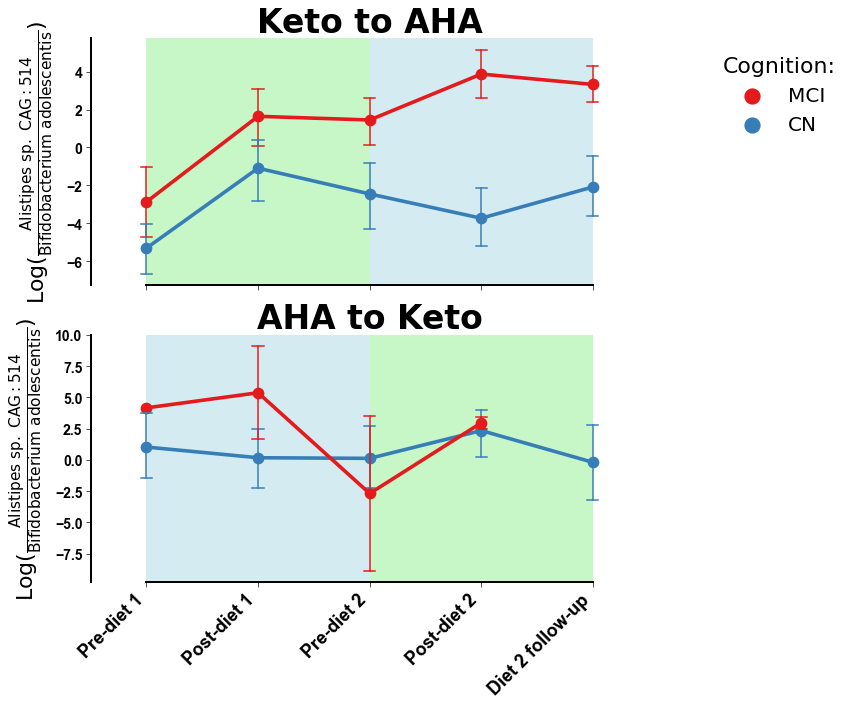

In [23]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10,10), sharex=True)

num_use = ['Alistipes sp. CAG:514']
#denoms_use = [['Akkermansia muciniphila']] * 2
denoms_use = [['Bifidobacterium adolescentis']] * 2
#denoms_use = [[x for x in bsh_sp if 'Bifidobacterium' in x]] * 2
subset_use = [1, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), denom_use, fsub in zip(enumerate(axn.flatten()), denoms_use, subset_use):

    num = taxonomy[taxonomy.species.isin(num_use)].index
    den = taxonomy[taxonomy.species.isin(denom_use)].index

    lr = np.log(btlr.loc[num, :].sum(0)) - np.log(btlr.loc[den, :].sum(0))
    lr[~np.isfinite(lr)] = np.nan
    mflr['log_ratio'] = lr
    
    


    orddf = mflr.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]

    if fsub == 2:
        orddf = orddf[~((orddf.timepoint_encoded == 5.0) & (orddf.cog == 'MCI'))]
        

    
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in denom_use]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in [num_use[0]]]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    
    
    label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                           ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))



    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=68, ax=ax,
                 errwidth=1.5, capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=22)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(1.1, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    


plt.show()


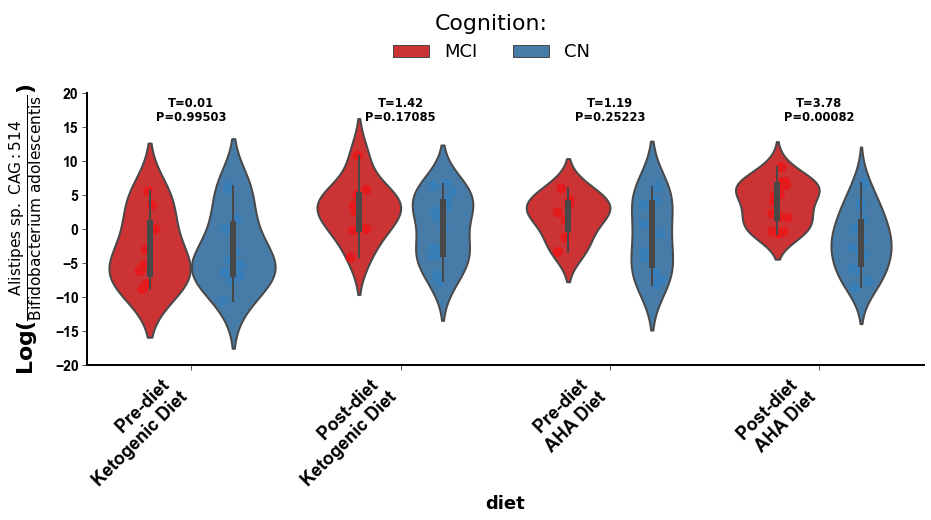

In [24]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'MCI':'#e41a1c', 'NC':'#377eb8'}

order_xaxis = ['Pre-diet \nKetogenic Diet',
                'Post-diet \nKetogenic Diet',
                'Pre-diet \nAHA Diet',
                'Post-diet \nAHA Diet']

fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)


orddf = mflr.copy()
num_use_label = ['Alistipes sp. CAG:514']
denom_use_label = ['Bifidobacterium adolescentis']
relabel_ticks = {1:'Pre-diet \n', 2:'Post-diet \n', 
                 3:'Pre-diet \n', 4:'Post-diet \n', 
                 5:'Post-diet \n'}

orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
orddf['p_plus_diet'] = orddf.Period + orddf.Diet


label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))



"""sns.pointplot(y='log_ratio', x='diet', hue='cog',rder=order_xaxis,
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)"""


sns.violinplot(x='p_plus_diet', y='log_ratio', hue='cog',order=order_xaxis,
             data=orddf, palette=cmap_man, ax=ax)
sns.stripplot(x='p_plus_diet', y='log_ratio', hue='cog',order=order_xaxis,
              data=orddf, palette=cmap_man, ax=ax, dodge=True, s=10)

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    tick.set_rotation(45)
    tick.set_ha('right')

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

#ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(0, 8)
#ax.set_ylim(0, 8)

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[2:], labels[2:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('18')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('diet',
              color='black',
              weight='bold',
              labelpad=5,
              fontsize=18)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


for x_i, ind in enumerate(order_xaxis):
    
    orddf_ = orddf[orddf.p_plus_diet == ind]
    x_ = orddf_[orddf_.cog == 'MCI'].log_ratio.values
    y_ = orddf_[orddf_.cog == 'NC'].log_ratio.values
    t_ = ttest_ind(x_, y_)
    p_str = "T=%.2f\nP=%.5f" % (t_.statistic, t_.pvalue)

    ax.text(x_i , 16,
            p_str,
            horizontalalignment='center',
            size='large', color='black', weight='semibold')
ax.set_ylim(-20, 20)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:],
                   [l.replace('NC','CN') for l in labels[:]],
                   loc=1, 
                         bbox_to_anchor=(.62, 1.35),
                         prop={'size':18},
                         title="Cognition:",
                         fancybox=False, framealpha=.0,
                         ncol=2, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.show()

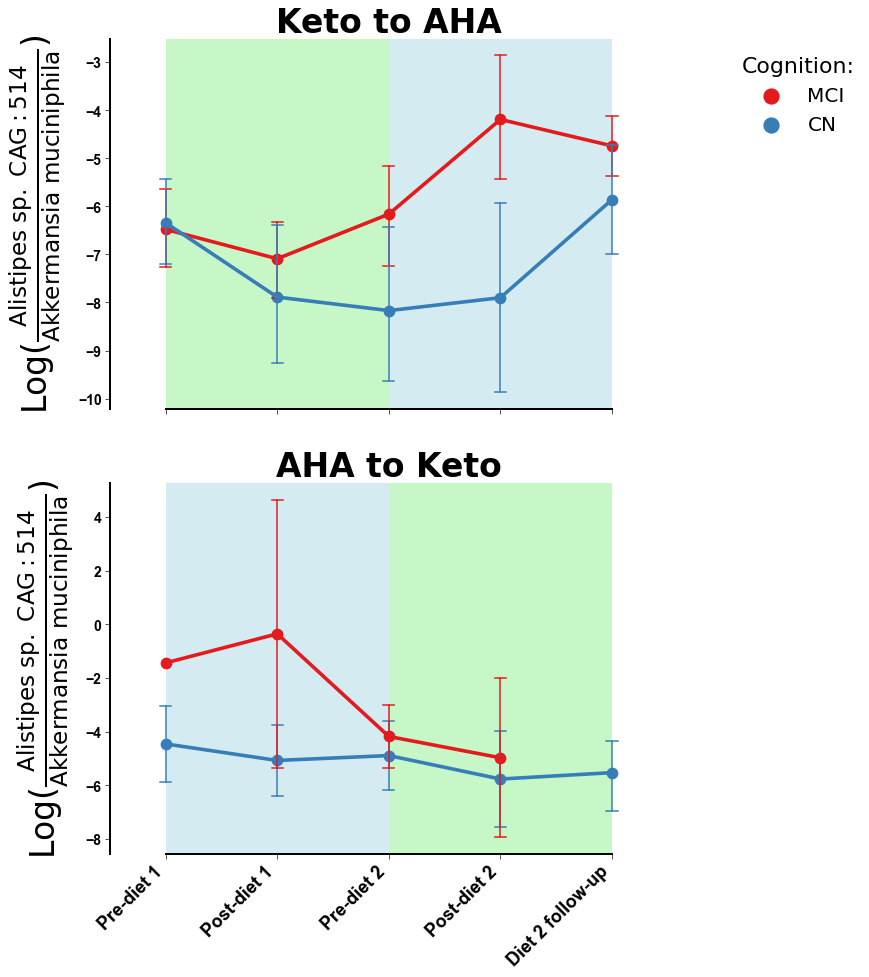

In [25]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10,15), sharex=True)

num_use = ['Alistipes sp. CAG:514']
denoms_use = [['Akkermansia muciniphila']] * 2
subset_use = [1, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), denom_use, fsub in zip(enumerate(axn.flatten()), denoms_use, subset_use):

    num = taxonomy[taxonomy.species.isin(num_use)].index
    den = taxonomy[taxonomy.species.isin(denom_use)].index

    lr = np.log(btlr.loc[num, :].sum(0)) - np.log(btlr.loc[den, :].sum(0))
    lr[~np.isfinite(lr)] = np.nan
    mflr['log_ratio'] = lr
    
    


    orddf = mflr.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]

    if fsub == 2:
        orddf = orddf[~((orddf.timepoint_encoded == 5.0) & (orddf.cog == 'MCI'))]
        

    
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in denom_use]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in [num_use[0]]]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    
    
    label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                           ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))



    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=68, ax=ax,
                 errwidth=1.5, capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=33)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(1.1, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    


plt.show()

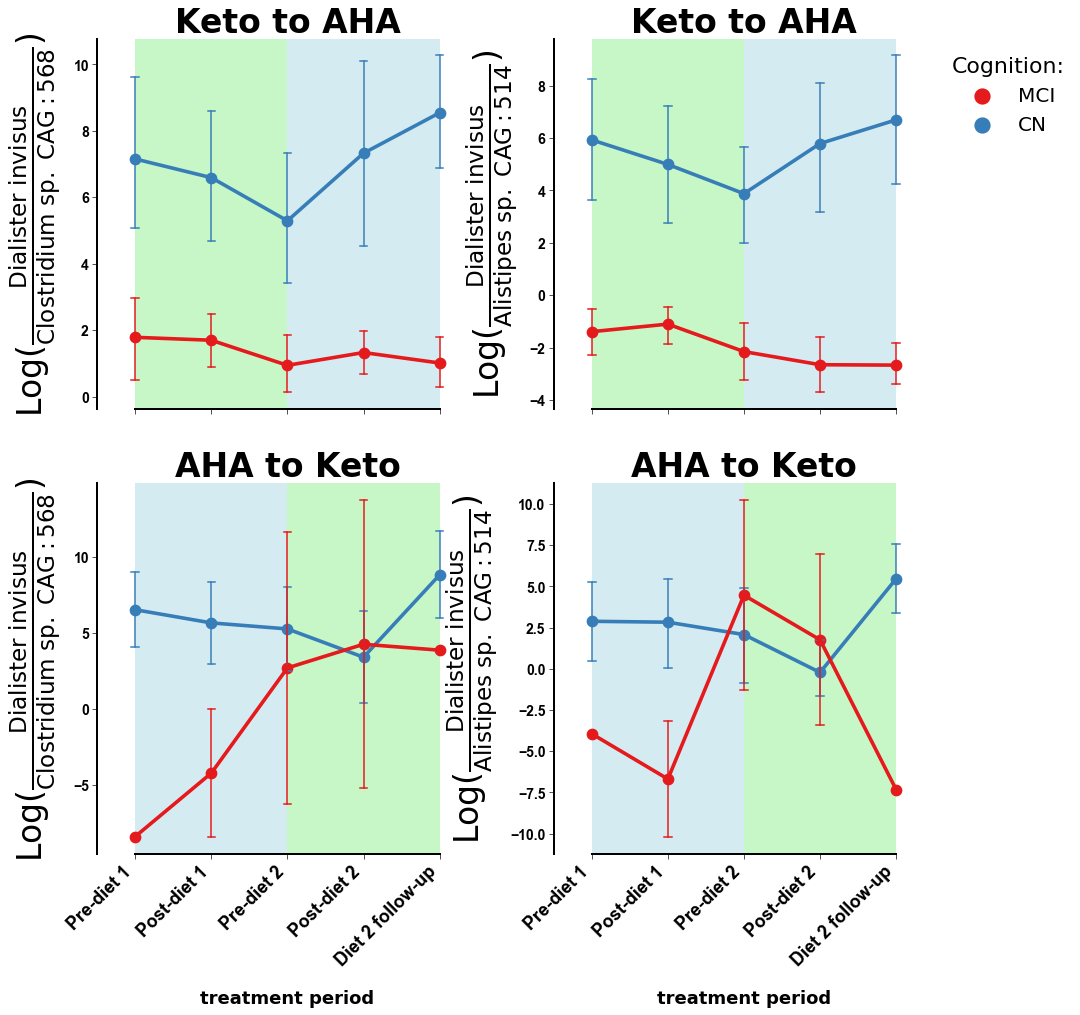

In [26]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,2, figsize=(15,15), sharex=True)


num_use = ['Dialister invisus', 'Dialister invisus CAG:218']
denoms_use = [['Clostridium sp. CAG:568'],
              ['Alistipes sp. CAG:514']] * 2
subset_use = [1, 1, 2, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), denom_use, fsub in zip(enumerate(axn.flatten()), denoms_use, subset_use):

    num = taxonomy[taxonomy.species.isin(num_use)].index
    den = taxonomy[taxonomy.species.isin(denom_use)].index

    lr = np.log(btlr.loc[num, :].sum(0)) - np.log(btlr.loc[den, :].sum(0))
    lr[~np.isfinite(lr)] = np.nan
    mflr['log_ratio'] = lr


    orddf = mflr.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in denom_use]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in [num_use[0]]]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    
    
    label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                           ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))



    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=68, ax=ax,
                 errwidth=1.5, capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=33)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(2.2, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    

    


plt.show()


# mmvec

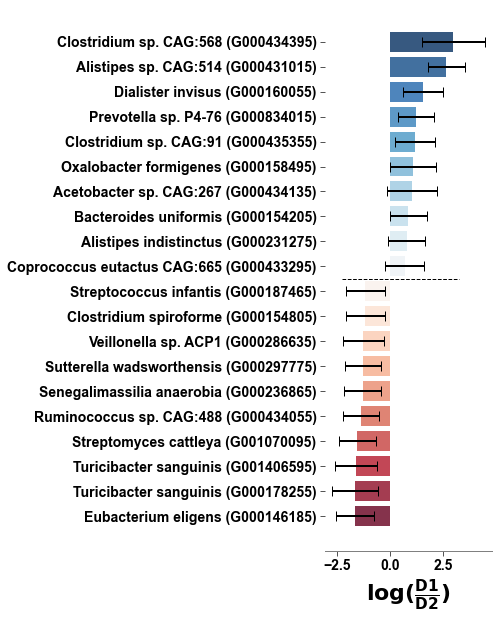

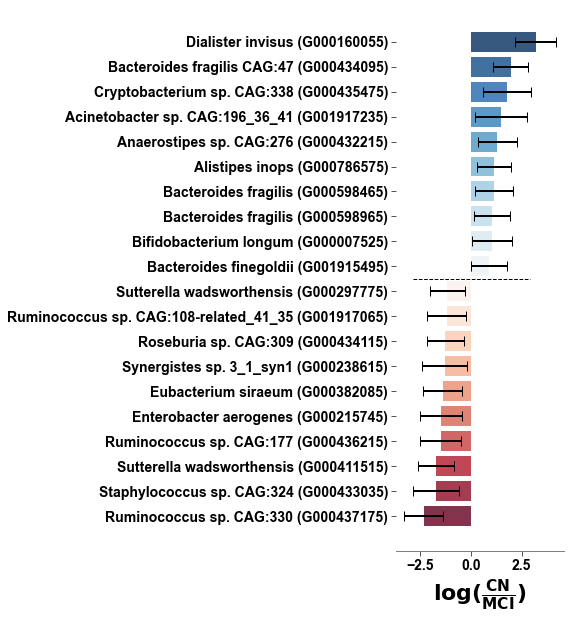

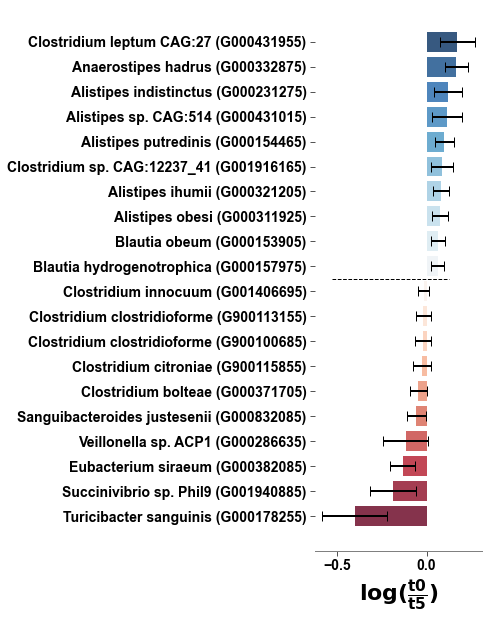

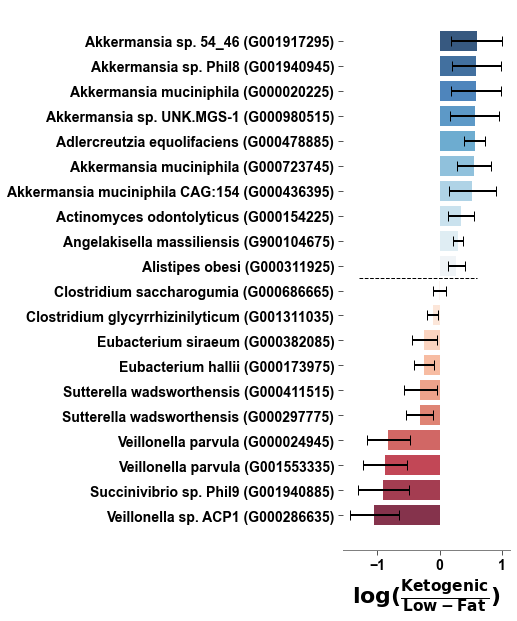

In [39]:


level = 'strain'

birdman_filttmp = {}

for label, diff_col in diff_plot.items():
    
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 10))

    #diff_col = "C(condition, Treatment('FT'))[T.FA]"
    micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
    #if 'Ketogenic' in  label:
    micro_comparedf = micro_comparedf[micro_comparedf[diff_col].abs() > micro_comparedf[diff_col.replace('_mean','_std')].abs()]

    title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label.split(':')[0], label.split(':')[1])
    ax, df_tmp = differential_plot(micro_comparedf,
                                   level, diff_col, diff_col,
                                   ax,
                                   quartile_partition=False,
                                   ntfilter=0,
                                   n_top_bottom_filter=True,
                                   n_top_bottom=20,
                                   #upper=.99, lower=.01, 
                                   xtitle=title_)
    birdman_filttmp[label] = df_tmp

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    #ax.set_xlim(-3, 3)
    #ax.spines['bottom'].set_bounds(-2, 2)
    ax.axhline((len(list(ax.get_yticklabels())) // 2) - .5,
               c='black', ls='--', lw=1,
               xmin=0.1, xmax=0.8)

    plt.show()


In [40]:
ketodf = pd.read_csv('../data/l5food.csv', index_col=0)
table_metab = q2.Artifact.load('../data/metabolomics/matched-table-L5-metaG.qza')
table_metab_df = table_metab.view(Table).to_dataframe()
metadata_metab = q2.Metadata.load('../data/metabolomics/matched-metadata-metaG.tsv')
table_metab.view(Table)


108 x 93 <class 'biom.table.Table'> with 4947 nonzero entries (49% dense)

In [41]:
mmvec_biplot = q2.Artifact.load('../results/mmvec/microbe-model-biplot.qza')
mmvec_conditionals = q2.Artifact.load('../results/mmvec/microbe-model-conditionals.qza')


In [42]:
mmvec_conditionals_df = mmvec_conditionals.view(q2.Metadata).to_dataframe()
mmvec_conditionals_df.head(5)


,apple,apple_cider,apricot,artichoke,avocado,banana,basil,bean,beef,blueberry,...,squid,strawberry,tea,tomato,trout,veal,walnut,wheat,worm,yogurt_cow
featureid,,,,,,,,,,,,,,,,,,,,,
G000006865,-1.992917,-1.902918,-1.942315,-0.324499,-2.065657,0.342789,-1.150962,-2.011690,-1.936605,-1.917752,...,-2.181343,-1.799602,-2.017310,-1.988698,-2.077759,-2.121884,-2.052805,-2.064460,-1.482837,-2.080325
G000006925,0.428846,0.438100,0.429193,0.283171,0.514648,0.585808,0.238120,0.421444,0.490775,0.460106,...,0.478244,0.356587,0.402670,0.438108,0.460513,0.489752,0.547839,0.422601,0.611876,0.444022
G000007525,0.439796,0.415065,0.480136,0.391658,0.616662,0.763749,0.266898,0.427925,0.488959,0.530416,...,0.530628,0.441948,0.356241,0.410705,0.463327,0.495434,0.697172,0.426132,0.652114,0.393275
G000008865,0.638942,0.620653,0.666204,0.622040,0.733918,0.814412,0.548824,0.630172,0.664111,0.685411,...,0.688108,0.645887,0.592643,0.621282,0.649071,0.665292,0.779770,0.630854,0.742815,0.609607
G000009925,2.734196,2.735543,2.743070,2.605909,2.797334,2.862437,2.557916,2.720770,2.792978,2.745447,...,2.773540,2.666997,2.716723,2.745092,2.758581,2.782904,2.827204,2.727261,2.875460,2.748449


In [43]:
#use_food = ['egg_chicken','chicken','avocado','cream', 'corn']

use_sp = list(set(micro_comparedf_subset_color.sort_values('cog[T.NC]_mean')['species'].values) - set(['Bacillus sp. CAG:988','Actinobaculum suis','Achromobacter denitrificans','Clostridium sp. CAG:967','Coprococcus sp. CAG:131','Prevotella sp. ne3005','Bacillus jeddahensis']))
use_sp = ['Bifidobacterium adolescentis', 'Akkermansia muciniphila', 'Dialister invisus',
          'Alistipes sp. CAG:514', 
          'Akkermansia muciniphila CAG:154',
          'Clostridium sp. CAG:568',
          'Akkermansia muciniphila',
          'Akkermansia sp. UNK.MGS-1']

dropme = ['basil','lettuce', 'mackerel', 'apricot', 'chicken', 'butterfish', 'coffee', 'tea', 'smelt', 
 'herring', 'pig', 'milk_cow','squid', 'beef', 'egg_chicken', 'veal', 'trout', 'yogurt_cow', 
          'carrot', 'banana', 'walnut', 'chia','orange','peach']

#use_sp = list(set(micro_comparedf_subset_color.sort_values('cog[T.NC]_mean')['species'].values))

use_sp_gotu = taxonomy[taxonomy.species.isin(use_sp)].index

"""col_use = 'CN:MCI'
col_use = 'Ketogenic:Low-Fat'
use_sp = [x.split(' (')[0] for x in birdman_filttmp[col_use].index]
use_sp_gotu = [x.split(' (')[1][:-1] for x in birdman_filttmp[col_use].index]
"""
use_food = ['egg_chicken', 'chicken', 'cream', 'blueberry',
            'cauliflower', 'meat_undetermined']


#use_food = ['egg_chicken', 'meat_undetermined']

#use_food = ['lamb', 'peanut', 'artichoke', 'meat_undetermined']


mmvec_conditionals_subset = mmvec_conditionals_df.loc[use_sp_gotu, ketodf.index].dropna(axis=0).T.drop(dropme)
print(mmvec_conditionals_subset.shape)
mmvec_conditionals_subset.head(5)


(33, 8)


Feature ID,G000010425,G000020225,G000160055,G000431015,G000434395,G000436395,G000723745,G000980515
apple,0.382805,1.699888,2.498039,-3.768324,-4.704339,1.802415,1.731853,1.843094
apple_cider,0.321103,1.703040,2.499788,-3.810503,-4.711345,1.806881,1.740647,1.863805
avocado,0.647333,1.703286,2.833979,-3.992611,-4.775078,1.815529,1.712374,1.846875
bean,0.347870,1.690219,2.522319,-3.785713,-4.654331,1.792671,1.724524,1.837722
blueberry,0.499369,1.682871,2.731314,-3.908490,-4.653768,1.790218,1.703376,1.825979


In [44]:
mmvec_conditionals_subset['ps'] = [ketodf.loc[x, 'keto'] for x in mmvec_conditionals_subset.index]

gene_color_map = {'no':'#377eb8',
                  'yes':'#4daf4a'}


metabclass = mmvec_conditionals_subset.pop("ps")
row_colors = metabclass.map(gene_color_map)


#mmvec_conditionals_subset.loc['sp', :] = [taxonomy.loc[str(i), 'species'].replace('_','').replace(']','').replace('[','').lstrip().rstrip()
#                                          for i in mmvec_conditionals_subset.columns]

sp_dict = taxonomy[taxonomy.species.isin(use_sp)]['species'].to_dict()
mmvec_conditionals_subset.columns = [sp_dict[x] for x in mmvec_conditionals_subset.columns]

mmvec_conditionals_subset.loc['sp', :] = [i
                                          for i in mmvec_conditionals_subset.columns]
taxonclass = mmvec_conditionals_subset.T.pop('sp').dropna()
#color = cm.RdBu(np.linspace(0, 1, len(use_sp)))  
#micro_color_map = {sp:to_hex(c) for sp, c in zip(use_sp, color)}
micro_color_map= {'Akkermansia muciniphila':'#4daf4a', 
        'Dialister invisus':'#4daf4a',
        'Bifidobacterium adolescentis':'#4daf4a',
        'Alistipes sp. CAG:514':'#377eb8', 
        'Akkermansia muciniphila CAG:154':'#4daf4a',
        'Clostridium sp. CAG:568':'#377eb8',
        'Akkermansia muciniphila':'#4daf4a', 
        'Akkermansia sp. UNK.MGS-1':'#4daf4a'}
col_colors = taxonclass.map(micro_color_map)

mmvec_conditionals_subset = mmvec_conditionals_subset.drop('sp')
mmvec_conditionals_subset = mmvec_conditionals_subset.astype(float)


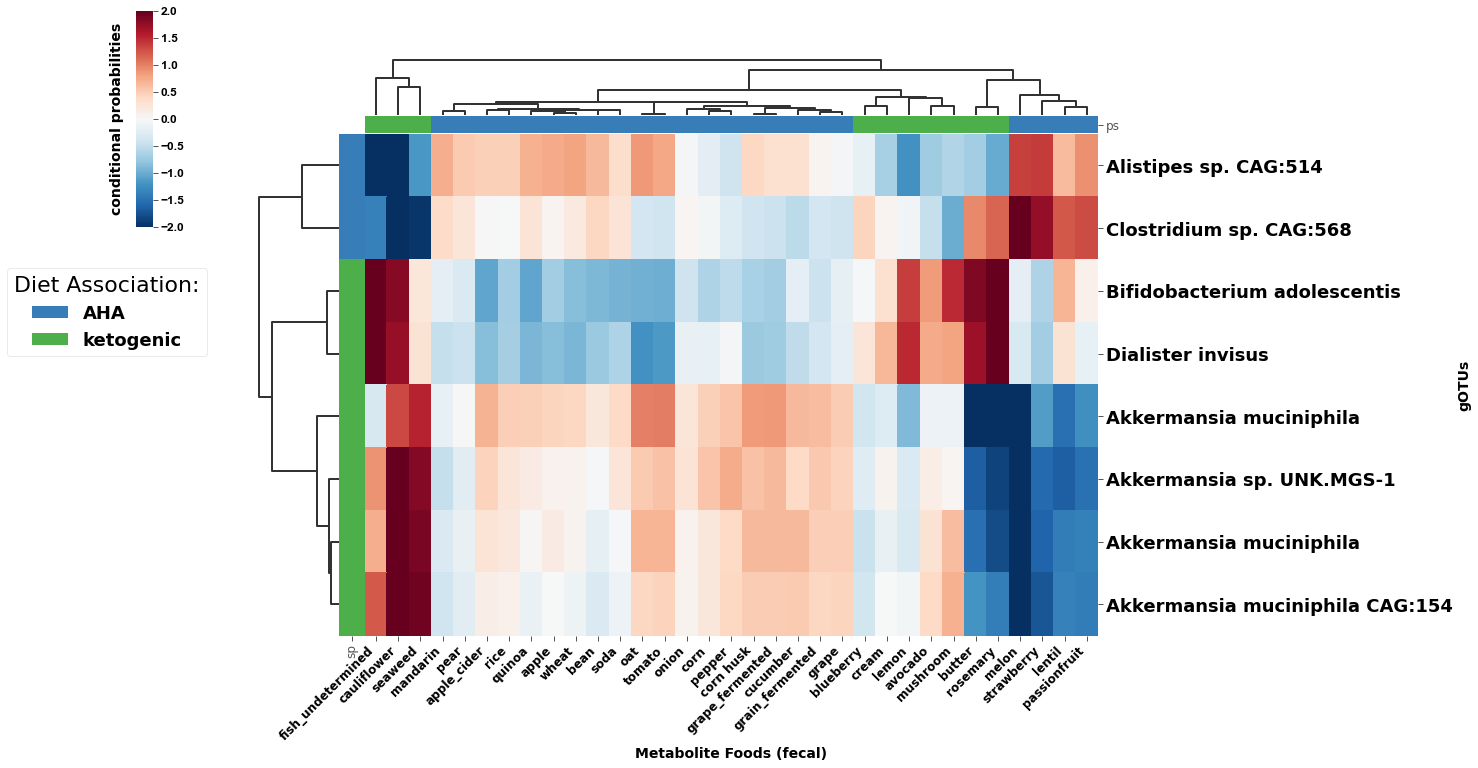

In [45]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)

g = sns.clustermap(mmvec_conditionals_subset.T,
                   vmax=2.0,
                   vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=row_colors,
                   row_colors=col_colors,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(15, 10),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=0)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('gOTUs' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('Metabolite Foods (fecal)' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


(33, 6)


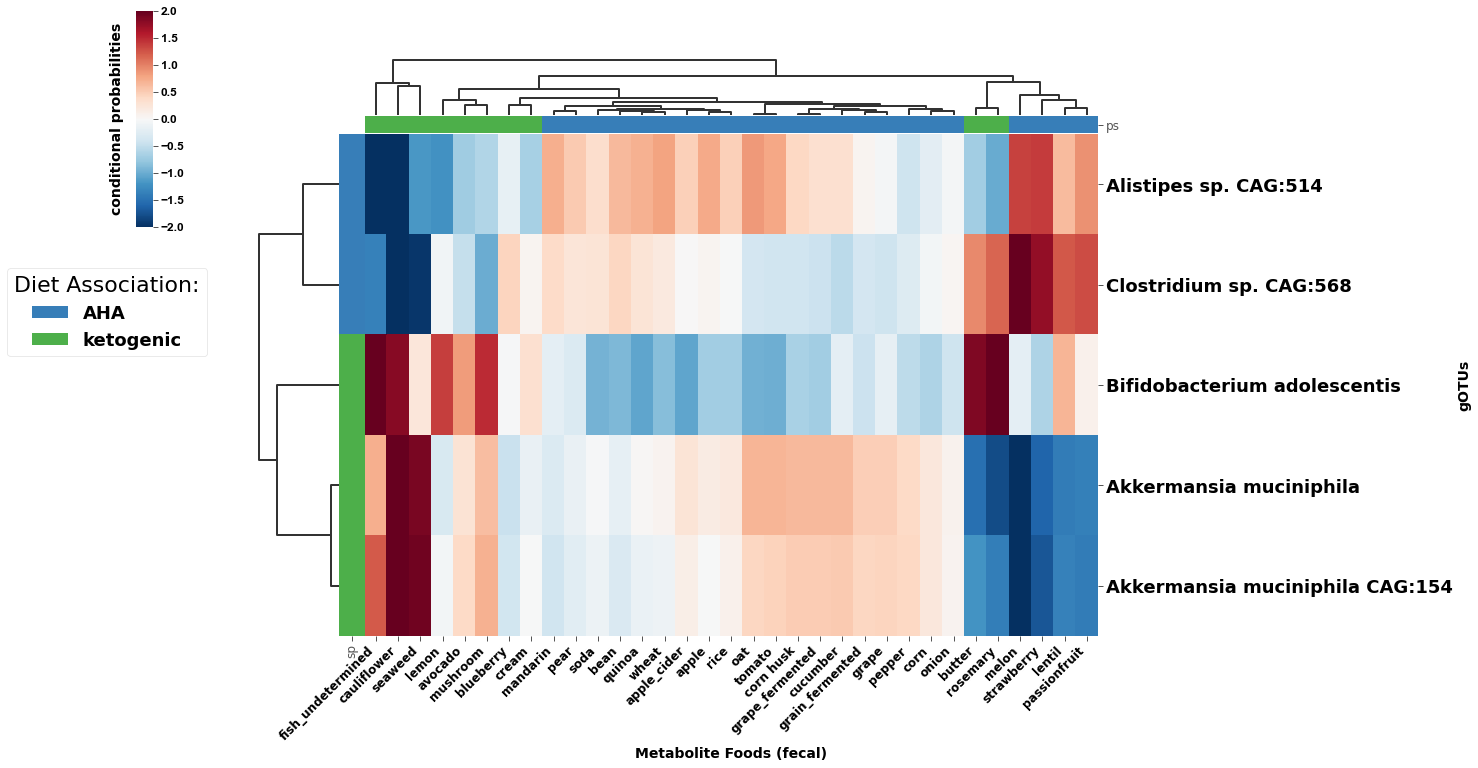

In [72]:

from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


#use_food = ['egg_chicken','chicken','avocado','cream', 'corn']

use_sp = list(set(micro_comparedf_subset_color.sort_values('cog[T.NC]_mean')['species'].values) - set(['Bacillus sp. CAG:988','Actinobaculum suis','Achromobacter denitrificans','Clostridium sp. CAG:967','Coprococcus sp. CAG:131','Prevotella sp. ne3005','Bacillus jeddahensis']))
use_sp = ['Bifidobacterium adolescentis', 
          'Alistipes sp. CAG:514', 
          'Akkermansia muciniphila CAG:154',
          'Clostridium sp. CAG:568',
          'Akkermansia muciniphila']

dropme = ['basil','lettuce', 'mackerel', 'apricot', 'chicken', 'butterfish', 'coffee', 'tea', 'smelt', 
 'herring', 'pig', 'milk_cow','squid', 'beef', 'egg_chicken', 'veal', 'trout', 'yogurt_cow', 
          'carrot', 'banana', 'walnut', 'chia','orange','peach']

#use_sp = list(set(micro_comparedf_subset_color.sort_values('cog[T.NC]_mean')['species'].values))

use_sp_gotu = taxonomy[taxonomy.species.isin(use_sp)].index

"""col_use = 'CN:MCI'
col_use = 'Ketogenic:Low-Fat'
use_sp = [x.split(' (')[0] for x in birdman_filttmp[col_use].index]
use_sp_gotu = [x.split(' (')[1][:-1] for x in birdman_filttmp[col_use].index]
"""
use_food = ['egg_chicken', 'chicken', 'cream', 'blueberry',
            'cauliflower', 'meat_undetermined']


#use_food = ['egg_chicken', 'meat_undetermined']

#use_food = ['lamb', 'peanut', 'artichoke', 'meat_undetermined']


mmvec_conditionals_subset = mmvec_conditionals_df.loc[use_sp_gotu, ketodf.index].dropna(axis=0).T.drop(dropme)
print(mmvec_conditionals_subset.shape)
mmvec_conditionals_subset = mmvec_conditionals_subset.loc[:,~mmvec_conditionals_subset.columns.duplicated()]


mmvec_conditionals_subset['ps'] = [ketodf.loc[x, 'keto'] for x in mmvec_conditionals_subset.index]

gene_color_map = {'no':'#377eb8',
                  'yes':'#4daf4a'}


metabclass = mmvec_conditionals_subset.pop("ps")
row_colors = metabclass.map(gene_color_map)


#mmvec_conditionals_subset.loc['sp', :] = [taxonomy.loc[str(i), 'species'].replace('_','').replace(']','').replace('[','').lstrip().rstrip()
#                                          for i in mmvec_conditionals_subset.columns]

sp_dict = taxonomy[taxonomy.species.isin(use_sp)]['species'].to_dict()
mmvec_conditionals_subset.columns = [sp_dict[x] for x in mmvec_conditionals_subset.columns]

mmvec_conditionals_subset.loc['sp', :] = [i
                                          for i in mmvec_conditionals_subset.columns]
taxonclass = mmvec_conditionals_subset.T.pop('sp').dropna()
#color = cm.RdBu(np.linspace(0, 1, len(use_sp)))  
#micro_color_map = {sp:to_hex(c) for sp, c in zip(use_sp, color)}
micro_color_map= {'Bifidobacterium adolescentis':'#4daf4a',
        'Alistipes sp. CAG:514':'#377eb8', 
        'Akkermansia muciniphila CAG:154':'#4daf4a',
        'Clostridium sp. CAG:568':'#377eb8',
        'Akkermansia muciniphila':'#4daf4a'}
col_colors = taxonclass.map(micro_color_map)

mmvec_conditionals_subset = mmvec_conditionals_subset.drop('sp')
mmvec_conditionals_subset = mmvec_conditionals_subset.astype(float)


color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)
mmvec_conditionals_subset = mmvec_conditionals_subset.loc[:,~mmvec_conditionals_subset.columns.duplicated()]


g = sns.clustermap(mmvec_conditionals_subset.T,
                   vmax=2.0,
                   vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=row_colors,
                   row_colors=col_colors.loc[~col_colors.index.duplicated()],
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(15, 10),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=0)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('gOTUs' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('Metabolite Foods (fecal)' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""


plt.show()


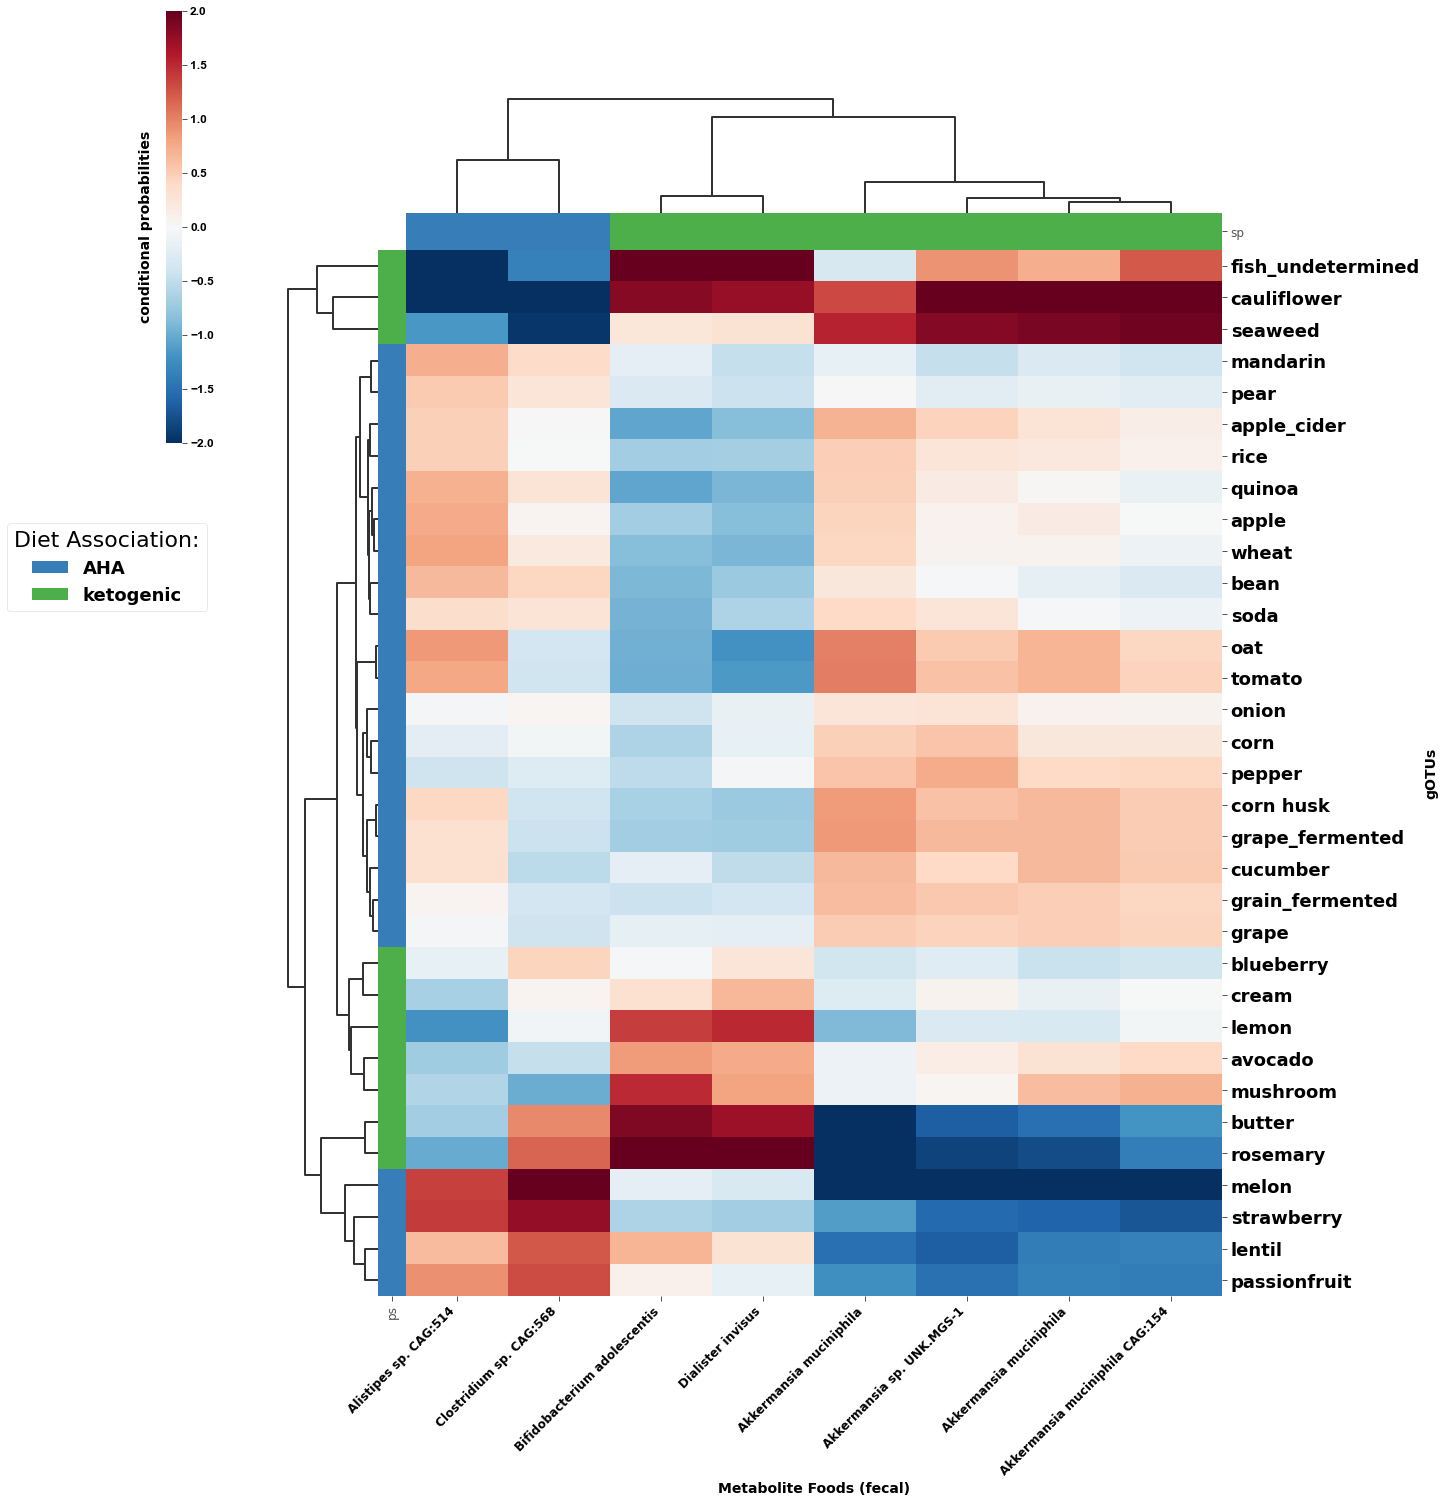

In [48]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)

g = sns.clustermap(mmvec_conditionals_subset,
                   vmax=2.0,
                   vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=col_colors,
                   row_colors=row_colors,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(15, 20),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=1)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('gOTUs' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('Metabolite Foods (fecal)' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""
plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
            """


plt.show()